## Decision tree

Decision tree is a statistical method used to build a classification model. With this model, one can describe how the values of the target variable is obtained using feature variables. Generally we want more than description of a dataset at hand from our model, we also want it to be able to predict future, "yet unseen" value of the target variable based on values of the feature variables. 

In the following, the 'Heart Failure Prediction Dataset' is used from kaggle.com : https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

The aim is to describe and predict occurrence of heart failure (=target variable) based on different attributes of the person (=features). 

### <ins>Data preparation<ins>


Let's import the required modules to define our feature set and target set using a copy of the original kaggle .csv file from my github repository:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv(
    "https://raw.githubusercontent.com/MMateo1120/machine_learning_tutorials/main/heart.csv"
)

features = data.columns[:-1]
target = data.columns[-1]

X = data[features]
y = data[target]

# original dataset:
data.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


#### *Data cleaning*
Let's check the features, from various perspectives. First check if missing values are in the dataset:

In [3]:
X.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
dtype: int64

There is no missing value in the dataset. Let's plot the values of the features:

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>],
       [<Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'FastingBS'}>],
       [<Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>]], dtype=object)

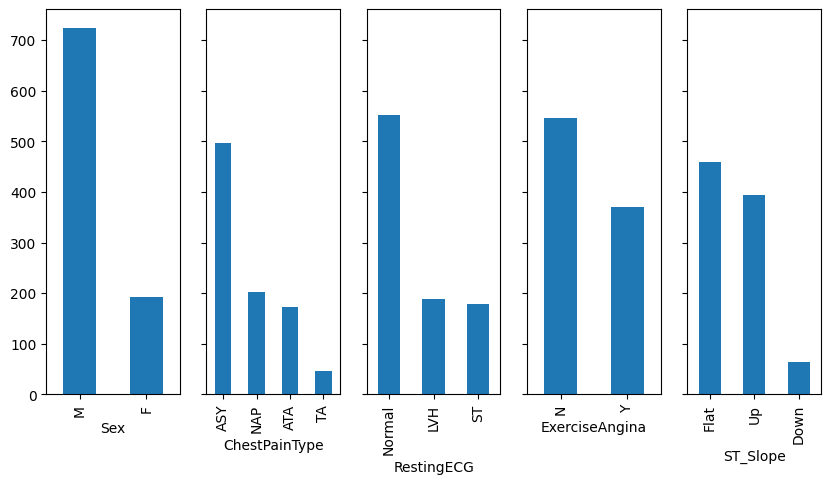

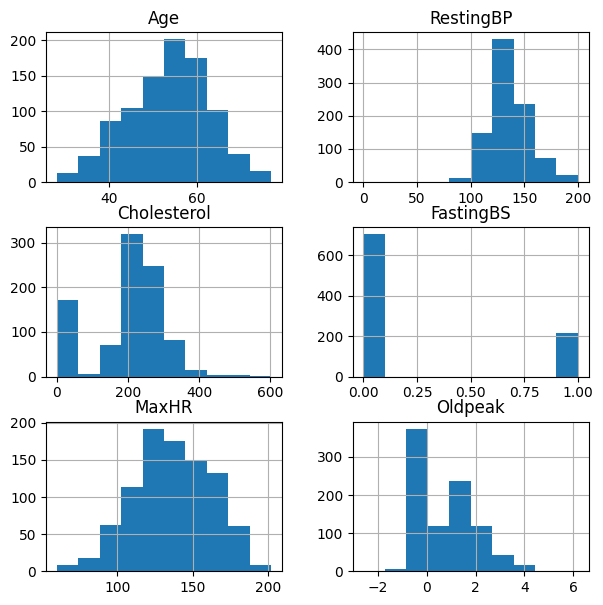

In [4]:
# finding features that are categorical based on the coding of their values:
categorical = []
for column in X.columns:
    if isinstance(X[column][0], str):
        categorical.append(column)

# plot categorical features in a shared figure
nrow = 1
ncol = X[categorical].shape[1]
fig, axes = plt.subplots(nrow, ncol, sharey=True, figsize=(10, 5))

for c in range(ncol):
    X[categorical[c]].value_counts().plot(kind="bar", ax=axes[c])

# plot features with seemingly continous values
X.hist(figsize=(7, 7))

Although the feautre 'Oldpeak' appears in the lower figure along with the continous features, it is categorical feature which is (already) coded with 0 and 1.
<br/>

Values of cholesterols seems to come from two different distributions: one that centered around 200, and one around 0. Let's plot the cholesterol data in id order:

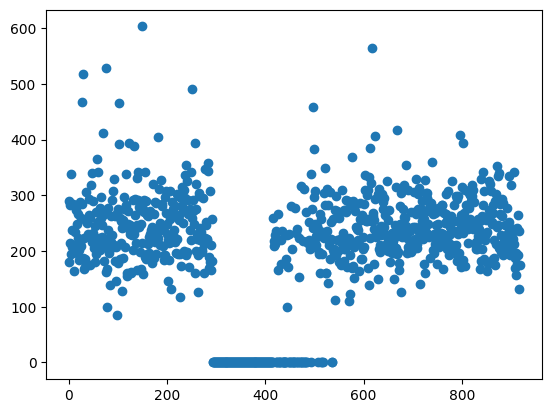

In [5]:
plt.scatter(X.index, X["Cholesterol"])

It seems the values between around id of 300 and 400 are all zeros, and up to 550 zeros appears in the dataset. The dataset is based on data from four sources as it is read at https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction, and it is possible that for some patients (maybe that belongs to one of the sources) cholesterol was not measured and used values of zero to fill the missing cells. Nonetheless, as no further information is available on these data, we will ommit these data from our dataset:

In [6]:
y = y.loc[X["Cholesterol"] > 0].to_frame().reset_index(drop=True)
X = X.loc[X["Cholesterol"] > 0].reindex().reset_index(drop=True)
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up
...,...,...,...,...,...,...,...,...,...,...,...
741,45,M,TA,110,264,0,Normal,132,N,1.2,Flat
742,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat
743,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat
744,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat


##### *Imbalance check*

Let's check the target values for imbalance issues:

<Axes: ylabel='count'>

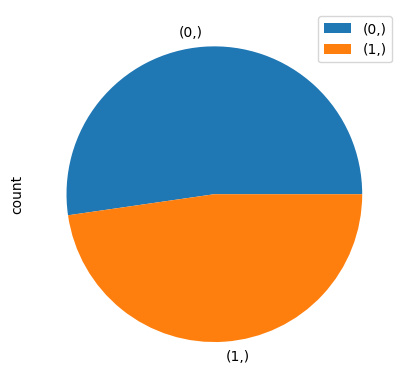

In [7]:
y.value_counts().to_frame().plot(kind='pie', y="count")

In the target variable '0' marks no occurrence heart failure and '1' marks occurrence of heart failure. As the ratio of 1 and 0 are close to 1, the target variable is balanced. 

#### *Transformation of X*

The decision tree method in sklearn cannot handle categorical features unless the levels are coded as integers. Let's first recode variables that only have two levels:


In [8]:
X["Sex"] = X["Sex"].map({"M": 0, "F": 1})
X["ExerciseAngina"] = X["ExerciseAngina"].map({"N": 0, "Y": 1})

Now, let's recode the variables that have more than two levels. For that, we cannot simply recode values into integers. That is beacuse if the columns consists more than two levels (for example 0,1 and 2) the method handle those as if there were relation between the levels. 
<br/>To recode, we need to transform the columns into wide form using for example `OneHotEncoder`:

In [9]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)

categorical.remove("Sex")
categorical.remove("ExerciseAngina")

for column in categorical:
    wide = onehot_encoder.fit_transform(X[column].to_frame())
    wide_df = pd.DataFrame(
        wide, columns=onehot_encoder.get_feature_names_out([column])
    )
    X = X.drop(columns=column)
    X = pd.concat([X, wide_df], axis=1)
X

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,0,140,289,0,172,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,1,160,180,0,156,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,0,130,283,0,98,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,1,138,214,0,108,1,1.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,0,150,195,0,122,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,0,110,264,0,132,0,1.2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
742,68,0,144,193,1,141,0,3.4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
743,57,0,130,131,0,115,1,1.2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
744,57,1,130,236,0,174,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


<br/>   

### <ins>Data evaluation I. : Fitting simple decision tree<ins>

Let's fit a decision tree on the data without specifying any conditions:

In [10]:
from sklearn import tree
import numpy as np

clf = tree.DecisionTreeClassifier()
clf.fit(X,y)

DecisionTreeClassifier()

Let's check the accuracy of our model, that is, how well it predicts the target values:

In [11]:
from sklearn import metrics

# predict target values for each data, based on their features' values:
y_pred = clf.predict(X)
# compare predicted and original target values
metrics.accuracy_score(y_pred,y)


1.0

It seems that our model is perfect, as it can predict target value in 100% of the cases. However, keep in mind, that we used the whole dataset for model building. While the model is perfect for description on the dataset at hand, it might fail in prediction of new values for an unseen dataset.

Let's check the importance of each feature:

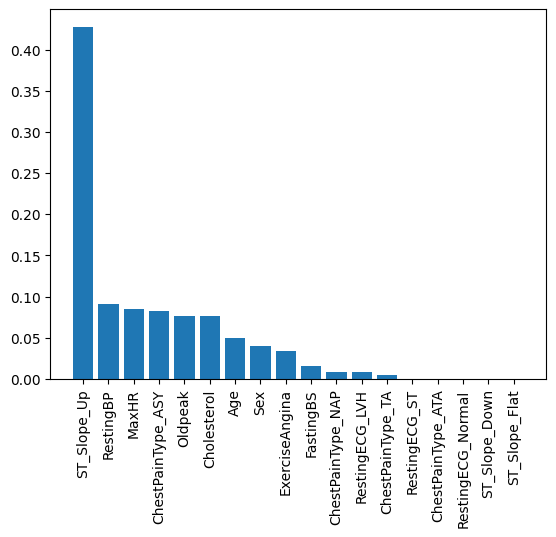

In [12]:
imps = clf.feature_importances_
imps = pd.Series(imps, index=X.columns.tolist())
imps = imps.sort_values(ascending=False)
plt.bar(imps.index,imps.values)
plt.xticks(rotation=90)
plt.show()

It seemes that the most important feature is 'ST_Slope_Up' followed by 'RestingBP', existance of ASY type 'ChestPainType', and many others. Having quite many features with low importance may indicate model overfit. 

Let's check the tree:

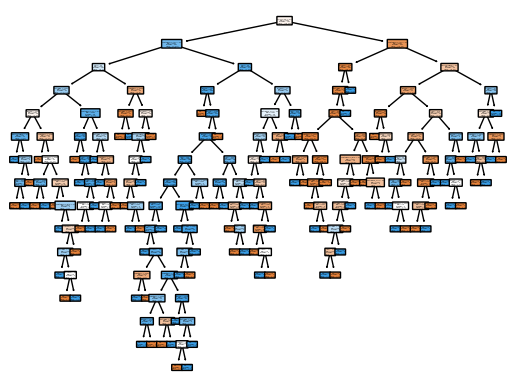

In [13]:
fig = plt.figure()
_ = tree.plot_tree(
    clf,
    feature_names=X.columns.tolist(),
    class_names=["No", "Yes"],
    filled=True,
    rounded=True,
)
plt.show()

It looks rather complex, which again may indicate overfit. Let's check the size of the samples at the end nodes, that is at the leaves:

<Axes: xlabel='number of samples at nod'>

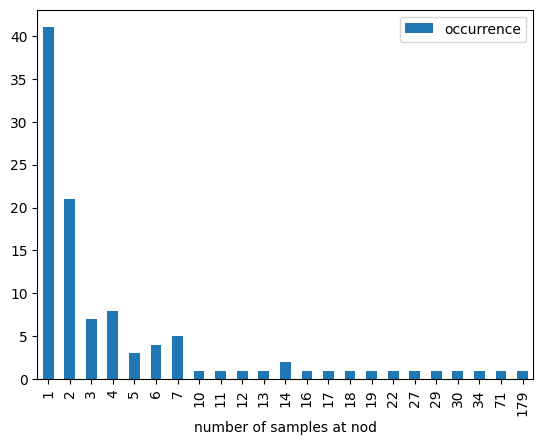

In [14]:
on_leaf = clf.apply(X)

leaves = []
y_np = y.to_numpy()
for i in np.unique(on_leaf):
    leaves.append(y_np[np.argwhere(on_leaf == i)])

sample_count = [len(leaves[count]) for count in range(len(leaves))]
sample_count = pd.DataFrame({"number of samples at nod": sample_count})
sample_count_occur = pd.DataFrame(
    {"occurrence": sample_count.groupby("number of samples at nod").size()}
)
sample_count_occur.plot.bar()

The plot tells us, that 40 leaves (which seems to be half of the leaves) has sample size of one, and size of two and three also occurs frequently. It tells us, that the model probably overfit and might not be reliable for prediction of a new dataset. We may want to simplifiy the tree to decrease the extent of overfit. 

<br/>   

### <ins>Data evaluation II. : Pruning the tree and cross-validation<ins>